In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
!pip install ngboost

from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=8e1ca6732e4f6eda442fb0ad3ab07ca1e4ddf73ea504c61080ef9878a258bd23
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset,PI Fatigue Life
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.142922e+02
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,4.216358e+04
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.078500e+06


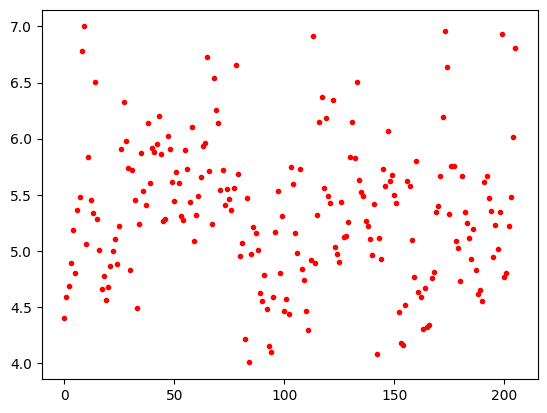

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles','Method','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-hot encoding the 'Test Type' column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life,Test Type_repeated,Test Type_reversed
0,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.020612e+03,False,True
1,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.256881e+03,False,True
2,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
3,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
4,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,9.634130e+03,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,1.722116e+07,True,False
202,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.016572e+06,True,False
203,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.078500e+06,True,False
204,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.211075e+06,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=0.9399 val_loss=0.9838 scale=1.0000 norm=0.5220
[iter 100] loss=0.5698 val_loss=0.6753 scale=2.0000 norm=0.7419
[iter 200] loss=0.1974 val_loss=0.4158 scale=2.0000 norm=0.7691
[iter 300] loss=-0.0988 val_loss=0.3031 scale=2.0000 norm=0.7559
== Early stopping achieved.
== Best iteration / VAL326 (val_loss=0.2903)
Pearson CC: 0.8407804243535708
R2 score: 0.7038565840793819
RMSE: 0.30992911655365507
MAE: 0.23371939939790393
Coverage: 92.85714285714286
Upper coverage: 97.61904761904762
Lower coverage: 95.23809523809524
Average Interval Width: 1.0832453689921508
Median Interval Width: 0.9675198758160239
Composite Metric: 0.9548211959616286


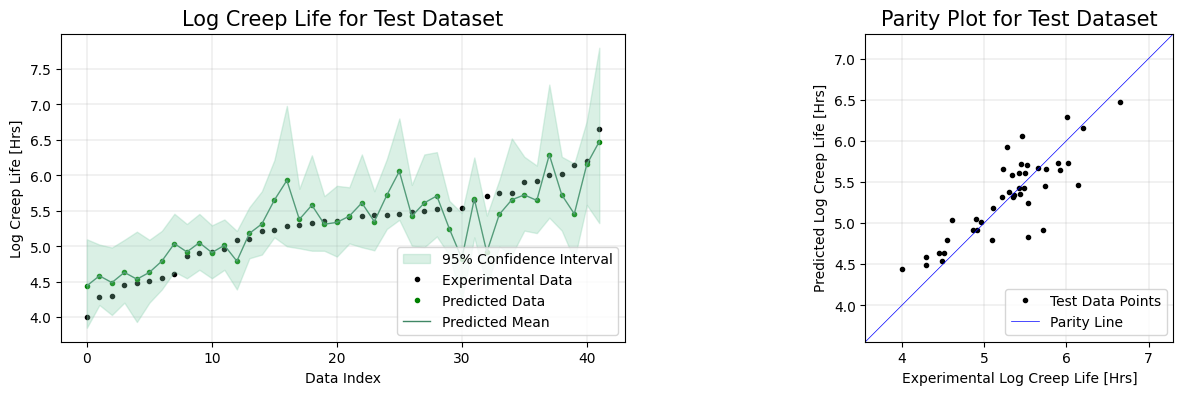

Run # 1 Fold # 2
[iter 0] loss=0.9036 val_loss=0.9536 scale=1.0000 norm=0.5455
[iter 100] loss=0.5222 val_loss=0.6006 scale=1.0000 norm=0.3720
[iter 200] loss=0.1837 val_loss=0.3615 scale=2.0000 norm=0.7721
[iter 300] loss=-0.1354 val_loss=0.2213 scale=2.0000 norm=0.7754
== Early stopping achieved.
== Best iteration / VAL308 (val_loss=0.2175)
Pearson CC: 0.7878850377830732
R2 score: 0.6202094040815684
RMSE: 0.4138096356808502
MAE: 0.29037169367898735
Coverage: 82.92682926829268
Upper coverage: 92.6829268292683
Lower coverage: 90.2439024390244
Average Interval Width: 1.2308009747437831
Median Interval Width: 1.0797824510813383
Composite Metric: 0.8534793386714199


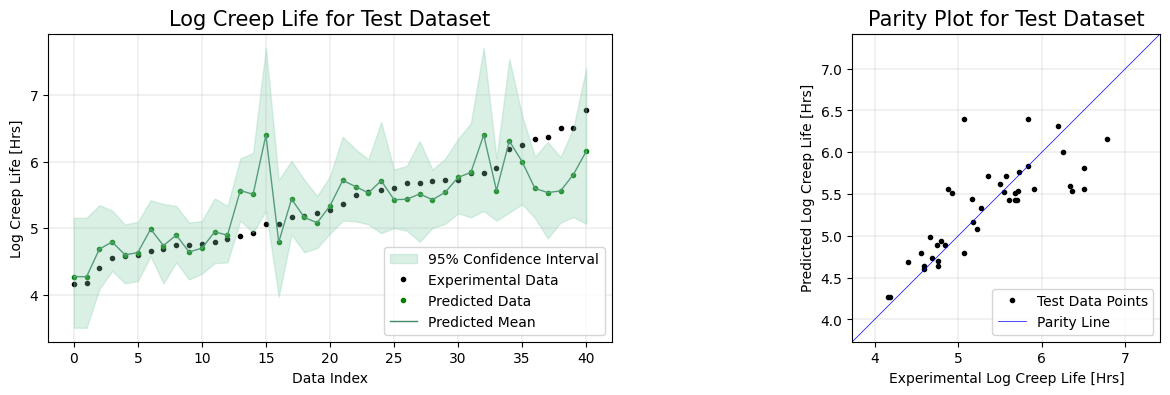

Run # 1 Fold # 3
[iter 0] loss=0.9550 val_loss=1.0030 scale=1.0000 norm=0.5345
[iter 100] loss=0.5806 val_loss=0.6621 scale=1.0000 norm=0.3771
[iter 200] loss=0.2467 val_loss=0.3501 scale=2.0000 norm=0.7706
[iter 300] loss=-0.0505 val_loss=0.1958 scale=2.0000 norm=0.7622
== Early stopping achieved.
== Best iteration / VAL340 (val_loss=0.1702)
Pearson CC: 0.8412009439856194
R2 score: 0.7038284383258728
RMSE: 0.2919853196333639
MAE: 0.20232979226551295
Coverage: 90.2439024390244
Upper coverage: 92.6829268292683
Lower coverage: 97.5609756097561
Average Interval Width: 0.9988637121327238
Median Interval Width: 0.9218237099920712
Composite Metric: 0.948030797706751


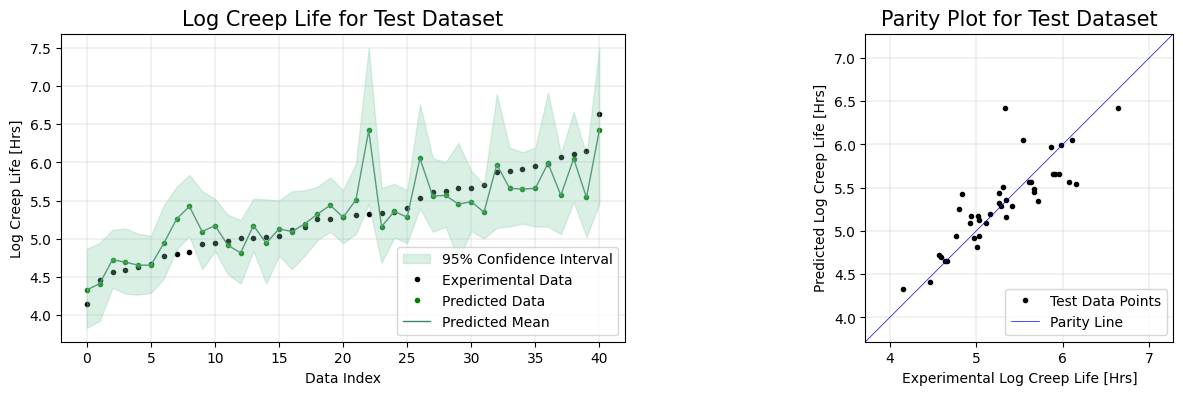

Run # 1 Fold # 4
[iter 0] loss=0.9286 val_loss=0.9670 scale=1.0000 norm=0.5073
[iter 100] loss=0.5664 val_loss=0.6842 scale=1.0000 norm=0.3453
[iter 200] loss=0.2742 val_loss=0.4474 scale=2.0000 norm=0.7412
[iter 300] loss=-0.0583 val_loss=0.3113 scale=2.0000 norm=0.7521
== Early stopping achieved.
== Best iteration / VAL297 (val_loss=0.3105)
Pearson CC: 0.7554636370916962
R2 score: 0.5588045310633163
RMSE: 0.4052619120507604
MAE: 0.2729947544667915
Coverage: 92.6829268292683
Upper coverage: 100.0
Lower coverage: 92.6829268292683
Average Interval Width: 1.3553298708549422
Median Interval Width: 1.199746814483575
Composite Metric: 0.9034992496477737


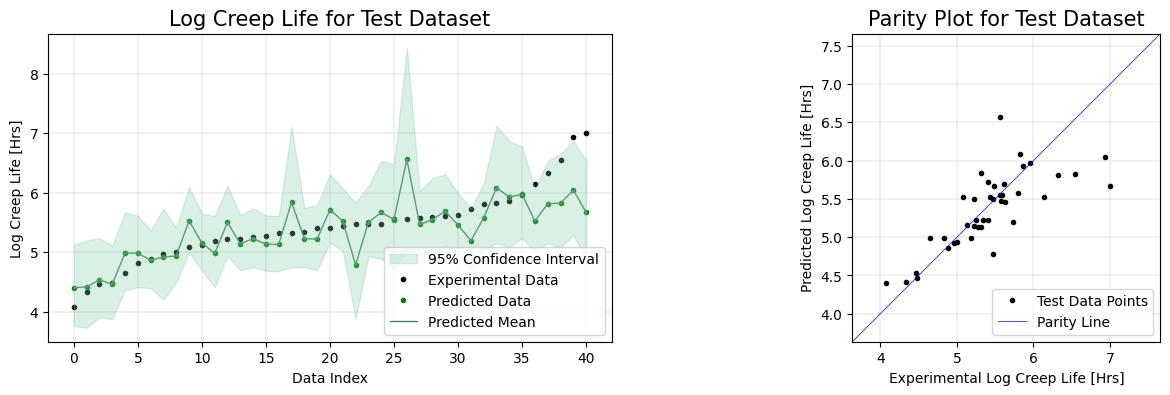

Run # 1 Fold # 5
[iter 0] loss=0.9031 val_loss=0.9168 scale=1.0000 norm=0.5293
[iter 100] loss=0.4900 val_loss=0.6107 scale=1.0000 norm=0.3689
[iter 200] loss=0.1463 val_loss=0.3780 scale=2.0000 norm=0.7976
[iter 300] loss=-0.1325 val_loss=0.2534 scale=2.0000 norm=0.8072
== Early stopping achieved.
== Best iteration / VAL308 (val_loss=0.2513)
Pearson CC: 0.7929750962153804
R2 score: 0.5957225770259653
RMSE: 0.44797681752123375
MAE: 0.27042602992869613
Coverage: 85.3658536585366
Upper coverage: 95.1219512195122
Lower coverage: 90.2439024390244
Average Interval Width: 1.0991690165144443
Median Interval Width: 1.066791809920717
Composite Metric: 0.8745914083676458


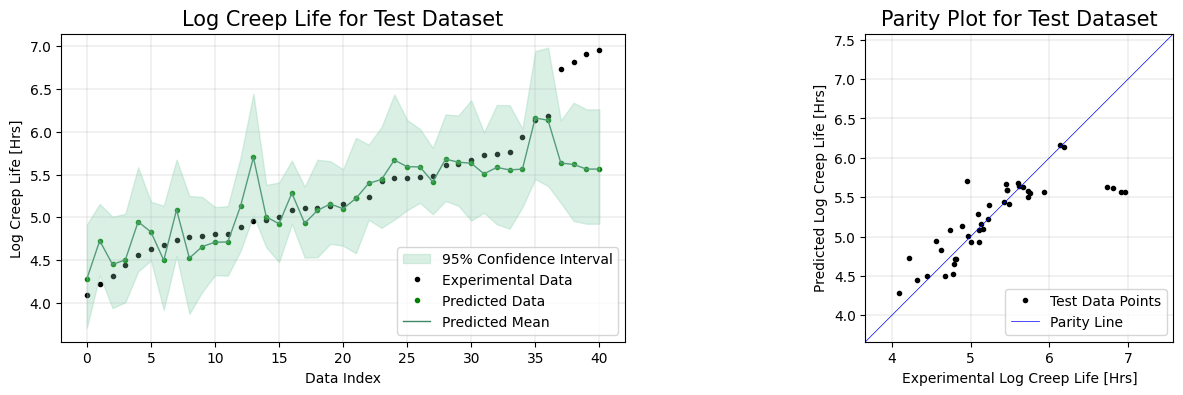

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)

            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)
            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')


            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.840780,0.703857,0.309929,0.233719,92.857143
1,0.787885,0.620209,0.413810,0.290372,82.926829
2,0.841201,0.703828,0.291985,0.202330,90.243902
3,0.755464,0.558805,0.405262,0.272995,92.682927
4,0.792975,0.595723,0.447977,0.270426,85.365854


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.803661,0.033085,0.636484,0.058369,0.373793,0.061426,0.253968,0.031732,88.815331,3.997717


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,92.857143,97.619048,95.238095,1.083245,0.967520,0.954821
1,82.926829,92.682927,90.243902,1.230801,1.079782,0.853479
2,90.243902,92.682927,97.560976,0.998864,0.921824,0.948031
3,92.682927,100.000000,92.682927,1.355330,1.199747,0.903499
4,85.365854,95.121951,90.243902,1.099169,1.066792,0.874591


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,88.815331,3.997717,95.62137,2.852418,93.193961,2.860634,1.153482,0.125308,1.047133,0.096731,0.906884,0.039743
